In [78]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [79]:
df = pd.read_csv("data.csv", parse_dates=True, index_col="Date")
print(df.head())

            Value
Date             
2023-01-11  100.4
2023-01-12  100.6
2023-01-13  100.8
2023-01-14  110.0
2023-01-15  110.2


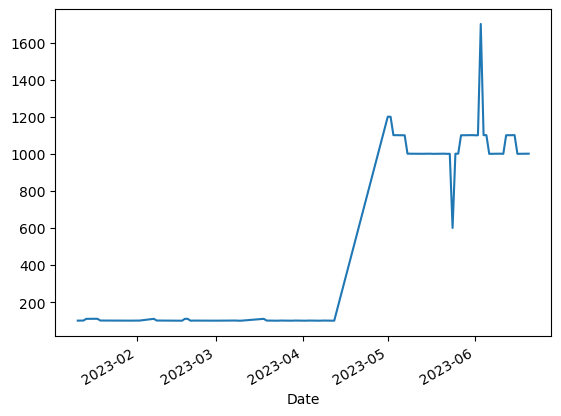

In [80]:
fig, ax = plt.subplots()
df.plot(legend=False, ax=ax)
plt.show()

In [81]:
train = df.loc[df.index <= "2023-04-12 00:00:00"]
test = df.loc[df.index > "2023-04-12 00:00:00"]
train.shape, test.shape

((79, 1), (51, 1))

            Value
Date             
2023-01-11  100.4
2023-01-12  100.6
2023-01-13  100.8
2023-01-14  110.0
2023-01-15  110.2


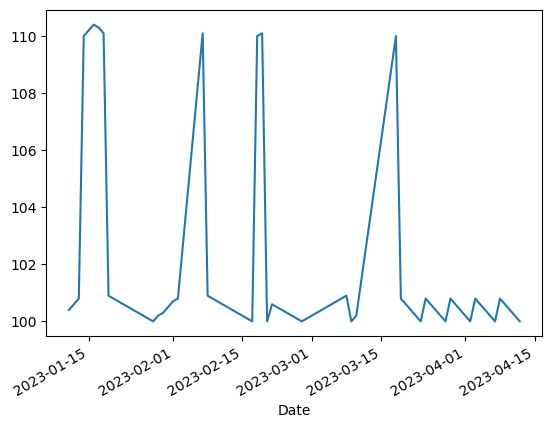

In [82]:
print(train.head())
fig, ax = plt.subplots()
train.plot(legend=False, ax=ax)
plt.show()

             Value
Date              
2023-05-01  1200.2
2023-05-02  1200.0
2023-05-03  1100.8
2023-05-04  1100.6
2023-05-05  1100.4


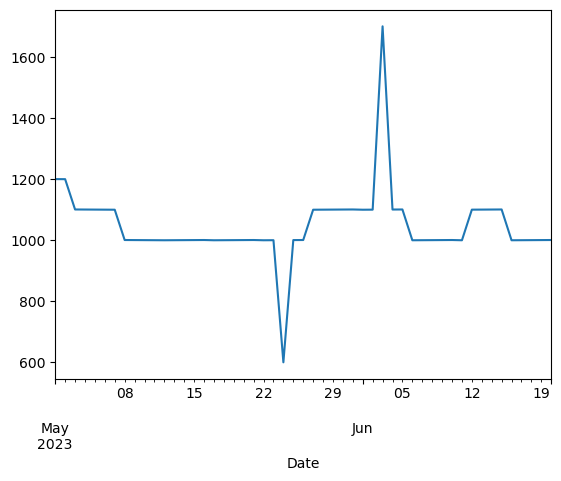

In [83]:
print(test.head())
fig, ax = plt.subplots()
test.plot(legend=False, ax=ax)
plt.show()

In [84]:
training_mean = train.mean()
training_std = train.std()
df_training_value = (train - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 79


In [85]:
TIME_STEPS = 16


def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (64, 16, 1)


In [86]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16, kernel_size=7, padding="same", activation="relu"),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=1, kernel_size=7, padding="same", activation="linear"
        ),
    ]
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 16, 32)            256       
                                                                 
 dropout_10 (Dropout)        (None, 16, 32)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 16, 16)            3600      
                                                                 
 conv1d_transpose_15 (Conv1D  (None, 16, 16)           1808      
 Transpose)                                                      
                                                                 
 dropout_11 (Dropout)        (None, 16, 16)            0         
                                                                 
 conv1d_transpose_16 (Conv1D  (None, 16, 32)           3616      
 Transpose)                                           

In [87]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.8969 - val_loss: 0.1430
Epoch 2/50
1/1 [==============================] - 0s 31ms/step - loss: 0.8751 - val_loss: 0.1429
Epoch 3/50
1/1 [==============================] - 0s 31ms/step - loss: 0.8500 - val_loss: 0.1420
Epoch 4/50
1/1 [==============================] - 0s 32ms/step - loss: 0.8211 - val_loss: 0.1409
Epoch 5/50
1/1 [==============================] - 0s 33ms/step - loss: 0.7986 - val_loss: 0.1397
Epoch 6/50
1/1 [==============================] - 0s 34ms/step - loss: 0.7629 - val_loss: 0.1384
Epoch 7/50
1/1 [==============================] - 0s 33ms/step - loss: 0.7357 - val_loss: 0.1370
Epoch 8/50
1/1 [==============================] - 0s 32ms/step - loss: 0.6786 - val_loss: 0.1356
Epoch 9/50
1/1 [==============================] - 0s 35ms/step - loss: 0.6376 - val_loss: 0.1339
Epoch 10/50
1/1 [==============================] - 0s 33ms/step - loss: 0.5973 - val_loss: 0.1318
Epoch 11/50
1/1 [==============

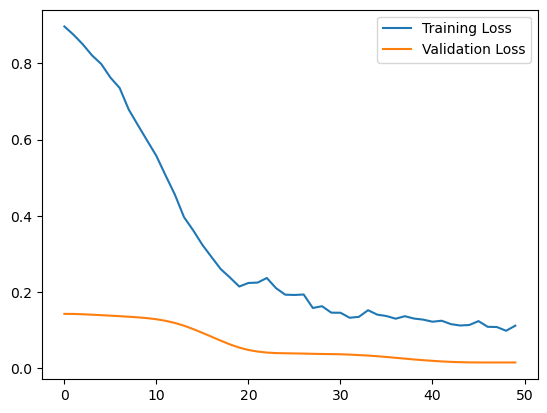

In [88]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

2/2 [==============================] - 0s 3ms/step


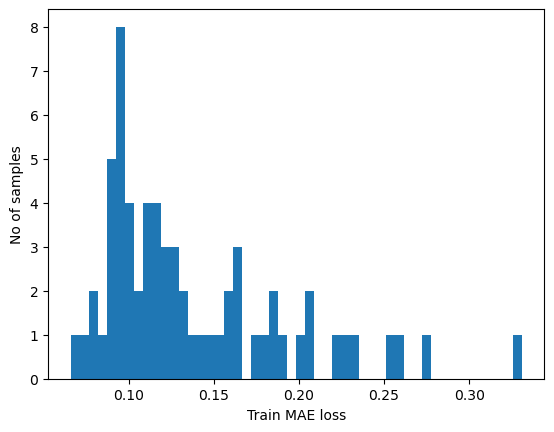

Reconstruction error threshold:  0.33080114519155845


In [89]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

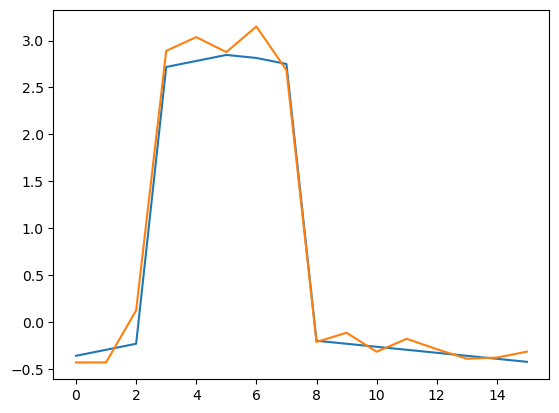

In [90]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

Test input shape:  (36, 16, 1)
2/2 [==============================] - 0s 3ms/step


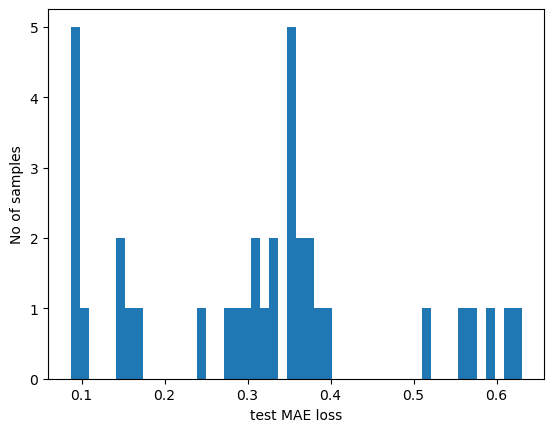

In [91]:
test_mean = test.mean()
test_std = test.std()
df_test_normalized = (test - test_mean) / test_std

x_test = create_sequences(df_test_normalized.values)
print("Test input shape: ", x_test.shape)

x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [92]:
anomalies = test_mae_loss > threshold
anomalies_indices = np.where(anomalies)[0]
anomaly_rows = test.iloc[anomalies_indices]

print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", anomalies_indices)
print(anomaly_rows)

Number of anomaly samples:  17
Indices of anomaly samples:  [ 8 15 16 17 18 19 20 21 22 23 24 25 26 27 28 32 33]
             Value
Date              
2023-05-09  1000.6
2023-05-16  1000.8
2023-05-17  1000.0
2023-05-18  1000.2
2023-05-19  1000.4
2023-05-20  1000.6
2023-05-21  1000.8
2023-05-22  1000.0
2023-05-23  1000.2
2023-05-24   600.4
2023-05-25  1000.6
2023-05-26  1000.8
2023-05-27  1100.0
2023-05-28  1100.2
2023-05-29  1100.4
2023-06-02  1100.2
2023-06-03  1700.4


# Python Code 

In [96]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers


def detect_anomalies(data_path):
    # Read data from the CSV file
    df = pd.read_csv(data_path, parse_dates=True, index_col="Date")

    # Split data into train and test sets
    train = df.loc[df.index <= "2023-04-12 00:00:00"]
    test = df.loc[df.index > "2023-04-12 00:00:00"]

    # Normalize the training data
    training_mean = train.mean()
    training_std = train.std()
    df_training_value = (train - training_mean) / training_std

    # Create sequences from the training data
    TIME_STEPS = 16

    def create_sequences(values, time_steps=TIME_STEPS):
        output = []
        for i in range(len(values) - time_steps + 1):
            output.append(values[i : (i + time_steps)])
        return np.stack(output)

    x_train = create_sequences(df_training_value.values)

    # Define and compile the autoencoder model
    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(filters=32, kernel_size=7, padding="same", activation="relu"),
            layers.Dropout(rate=0.2),
            layers.Conv1D(filters=16, kernel_size=7, padding="same", activation="relu"),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=1, kernel_size=7, padding="same", activation="linear"
            ),
        ]
    )

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    # Train the model
    history = model.fit(
        x_train,
        x_train,
        epochs=50,
        batch_size=128,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
    )

    # Get train MAE loss
    x_train_pred = model.predict(x_train)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

    # Get reconstruction loss threshold
    threshold = np.max(train_mae_loss)

    # Normalize the test data
    test_mean = test.mean()
    test_std = test.std()
    df_test_normalized = (test - test_mean) / test_std

    x_test = create_sequences(df_test_normalized.values)

    # Get test MAE loss
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    # Detect anomalies
    anomalies = test_mae_loss > threshold
    anomalies_indices = np.where(anomalies)[0]

    # Get anomaly timestamps
    anomaly_timestamps = test.index[anomalies_indices]

    return anomaly_timestamps

detect_anomalies("data.csv")

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.8887 - val_loss: 0.1334
Epoch 2/50
1/1 [==============================] - 0s 32ms/step - loss: 0.8674 - val_loss: 0.1270
Epoch 3/50
1/1 [==============================] - 0s 33ms/step - loss: 0.8413 - val_loss: 0.1200
Epoch 4/50
1/1 [==============================] - 0s 31ms/step - loss: 0.8143 - val_loss: 0.1124
Epoch 5/50
1/1 [==============================] - 0s 33ms/step - loss: 0.7930 - val_loss: 0.1038
Epoch 6/50
1/1 [==============================] - 0s 31ms/step - loss: 0.7634 - val_loss: 0.0942
Epoch 7/50
1/1 [==============================] - 0s 32ms/step - loss: 0.7149 - val_loss: 0.0838
Epoch 8/50
1/1 [==============================] - 0s 34ms/step - loss: 0.6787 - val_loss: 0.0726
Epoch 9/50
1/1 [==============================] - 0s 36ms/step - loss: 0.6318 - val_loss: 0.0608
Epoch 10/50
1/1 [==============================] - 0s 35ms/step - loss: 0.5848 - val_loss: 0.0490
Epoch 11/50
1/1 [==============

DatetimeIndex(['2023-05-19', '2023-05-20', '2023-05-21', '2023-05-22',
               '2023-05-23', '2023-05-24'],
              dtype='datetime64[ns]', name='Date', freq=None)